# Pipeline Notebook for Base Models

### Contains Pipelines for Random Forrest, SVC and XGBoost Model


### Import the Libraries

In [48]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import pickle

KeyboardInterrupt: 

### Define our Parameters

In [44]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 0

### Import the Dataframe with Custom Functions

Use this Code for Preprocessing!!! Otherwise the Models will have another Performance due to the Target Variable!

In [20]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 45 columns
 -> there are 45 numerical columns
 -> there are 0 categoricals columns


### This Line is Crucial for our Model Performance! We kick out Wrong Measurements with this

In [21]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

# Examining the Columns we need and produce Feature Lists for each Model

### Defining the Lists for the Features each Model uses


In [22]:
# 11 Features on Best SVC Model
svc_feature_list = ["sp_fix_duration_ms_total","sp_fix_duration_ms_mean","sp_fix_duration_ms_var", "sam_sal_first_fixation","sam_sal_sum",
                    "sam_sal_KLD", "obj_t_abs_on_background","obj_t_abs_on_animate", "obj_n_fix_background","obj_n_fix_inanimate",
                    "obj_n_fix_animate"]

# Features on Best XGB Model
xgb_feature_list = ['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',
       'dg_sal_first_fixation', 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
       'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS', 'obj_t_abs_on_face',
       'obj_t_rel_on_face', 'obj_t_abs_on_animate', 'obj_t_abs_on_inanimate',
       'obj_t_abs_on_background', 'obj_t_rel_on_animate',
       'obj_t_rel_on_inanimate', 'obj_t_rel_on_background']

# Best Features for Random Forrest Model
rf_feature_list = ['sp_fix_count', 'sp_fix_duration_ms_total', 'sp_fix_duration_ms_mean',
 'sp_fix_duration_ms_var', 'sp_len_px_total', 'sp_saccade_amplitude_px_mean',
 'sp_saccade_amplitude_px_var', 'sp_distance_to_centre_px_mean',
 'sp_distance_to_centre_px_var', 'sp_distance_to_sp_mean_px_mean',
 'sp_distance_to_sp_mean_px_var', 'dg_sal_first_fixation', 'dg_sal_mean',
 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
 'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS',
 'obj_t_abs_on_animate', 'obj_t_abs_on_background']

# Transformers, Preproccessing and Pipeline for our 3 Base Models

### SVC Model

In [23]:
# Setting up a Transformer for SVC with my Custom Function and the Scaler

transformer_svc = [
    ("scaler", StandardScaler(), svc_feature_list)
]

# Wrap a ColumnTransformer around the transformer_svc

preprocessing_svc = ColumnTransformer(transformer_svc, remainder="drop")

# pack the preprocessing steps into a Pipeline
svc_pipeline = Pipeline([
    ("preprocessor", preprocessing_svc),
    ("classifier", SVC(C=0.1, degree=4, kernel='poly',gamma='scale', probability=True))
])


### XGBoost Model

In [24]:
# Setting up a Transformer for SVC with my Custom Function and the Scaler

transformer_xgb = [
                   ("scaler", MinMaxScaler(),xgb_feature_list)
                   ]

# Wrap a ColumnTransformer around the transformer_svc

preprocessing_xgb = ColumnTransformer(transformer_xgb, remainder="drop")

# pack the preprocessing steps into a Pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessing_xgb),
    ("classifier", XGBClassifier(learning_rate = 0.01, max_depth=5, n_estimators=100))
])

### Random Forrest Pipeline

In [32]:
# Define the feature selector function
def feature_selector(df, features_to_keep):
    return df[features_to_keep]

# Define the transformer for Random Forest
transformer_rf = [
    ("feature_selector", FunctionTransformer(feature_selector, kw_args={"features_to_keep": rf_feature_list}), rf_feature_list)
]

# Wrap a ColumnTransformer around the transformer_rf
preprocessing_rf = ColumnTransformer(transformer_rf, remainder="drop")

# Create the Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessing_rf),
    ("classifier", RandomForestClassifier(max_depth=7,
    max_features="sqrt",
    min_samples_leaf=40,
    min_samples_split=50,
    n_estimators=50,
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,))
])

# Stacking Pipelines! Predict Class & Predict Proba (Error Analysis)
- Pipelines with Logistic Regression Classifier
- One for Predicting Classes 1 for Predicting Probabilities
- You can make a full run out of the DF or Preload the 3 Base Models


In [42]:
# Define an empty Master Model - LogReg
master_model = LogisticRegression()

# Stacking Classifier Pipeline
stacking_pipeline_predict = StackingClassifier(
    estimators=[
        ('svc', svc_pipeline),
        ('xgb', xgb_pipeline),
        ('rf', rf_pipeline)
    ],
    final_estimator=master_model,
    cv=cv,
    stack_method='predict_proba',
    passthrough=True,
    
)



# Grid Search Pipeline for our Master Model!

### The Grid Search Grid for the Master Model

In [46]:
param_grid = {
    'final_estimator__C': np.logspace(-3, 3, 10),  # Reduced values for C
    'final_estimator__penalty': ['l1', 'l2'],  # Removed 'elasticnet'
    'final_estimator__solver': ['liblinear', 'lbfgs', 'saga'],  # Removed 'newton-cg', 'sag'
    'final_estimator__class_weight': [None, 'balanced'],  # Class weights
    'final_estimator__max_iter': [200, 1000, 2000],  # Reduced maximum number of iterations
    'final_estimator__tol': [1e-4, 1e-3],  # Reduced tolerance for stopping criteria
    'final_estimator__fit_intercept': [True, False],  # Whether to calculate the intercept
    'final_estimator__l1_ratio': [None, 0.1, 0.5, 0.9]  # Elastic-Net mixing parameter
}

### The Grid Search Pipeline

In [43]:
# Grid search for hyperparameter tuning of the master model
grid_search_pipeline = GridSearchCV(
    estimator=stacking_pipeline_predict,
    param_grid=param_grid,
    cv=cv,
    scoring=ftwo_scorer,
    verbose = verbose,
    n_jobs=n_jobs

)

## Train Test Split - Use this for all Models!!! Pipelines do your Feature Selection
- We do the Train Test Split on the Whole Dataframe
- Each Pipeline will get the Features it needs from it
- So only 1 Split to run all Model on 

In [8]:
# prepare features and target
X = df.drop("asd", axis=1)
y = df["asd"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '44' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


## Quick Check for each Base Model if Pipeline gives the same Output

### SVC Model Pred + Analysis

In [9]:
# Fit the svc_pipeline on the training data
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['sp_fix_duration_ms_total',
                                                   'sp_fix_duration_ms_mean',
                                                   'sp_fix_duration_ms_var',
                                                   'sam_sal_first_fixation',
                                                   'sam_sal_sum', 'sam_sal_KLD',
                                                   'obj_t_abs_on_background',
                                                   'obj_t_abs_on_animate',
                                                   'obj_n_fix_background',
                                                   'obj_n_fix_inanimate',
                                                   'obj_n_fix_animate'])])),
                ('classifier',
                 SVC(C=0.1, degree=4, kernel='poly', probability=True))])

In [10]:
# Predict on the test set
y_pred_train = svc_pipeline.predict(X_train)
y_proba_train = svc_pipeline.predict_proba(X_train)
y_pred_test = svc_pipeline.predict(X_test)
y_pred_proba_test = svc_pipeline.predict_proba(X_test)


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.740     0.418     0.534      3252
           1      0.593     0.852     0.699      3233

    accuracy                          0.635      6485
   macro avg      0.666     0.635     0.617      6485
weighted avg      0.667     0.635     0.617      6485

f(0.5)-score: 0.631
f(2.0)-score: 0.784

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.774     0.453     0.571       371
           1      0.606     0.864     0.712       361

    accuracy                          0.656       732
   macro avg      0.690     0.659     0.642       732
weighted avg      0.691     0.656     0.641       732

f(0.5)-score: 0.644
f(2.0)-score: 0.796



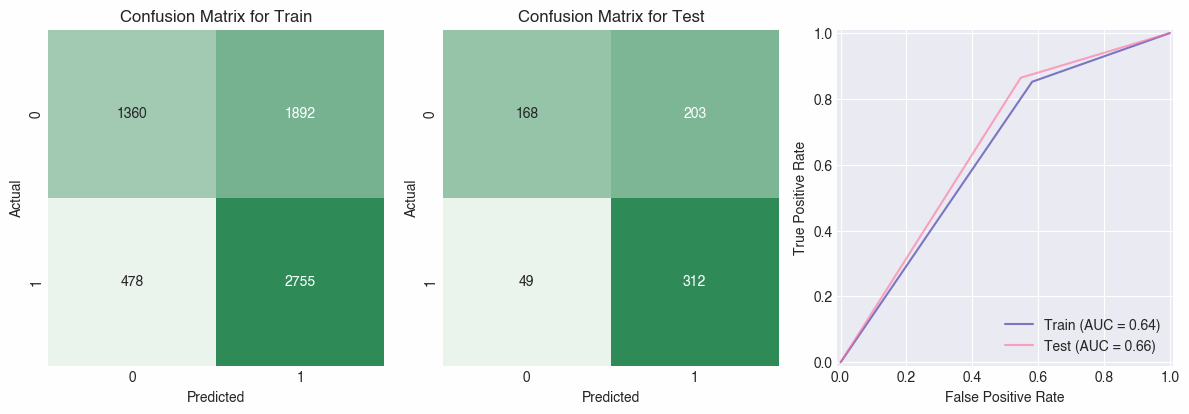

In [11]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=y_pred_train,
    y_train_proba=y_proba_train,
    y_test=y_test,
    y_test_pred=y_pred_test,
    y_test_proba=y_pred_proba_test,
)

### RF Model Pred + Analysis

In [33]:
# Fit the rf_pipeline on the training data
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('feature_selector',
                                                  FunctionTransformer(func=<function feature_selector at 0x2eb5468e0>,
                                                                      kw_args={'features_to_keep': ['sp_fix_count',
                                                                                                    'sp_fix_duration_ms_total',
                                                                                                    'sp_fix_duration_ms_mean',
                                                                                                    'sp_fix_duration_ms_var',
                                                                                                    'sp_len_px_total',
                                                                                                    'sp_saccade_amplitude_px_mean',
                                                                                                    'sp_saccade_amplitude_px_var',...
                                                   'sp_distance_to_sp_mean_px_var',
                                                   'dg_sal_first_fixation',
                                                   'dg_sal_mean', 'dg_sal_sum',
                                                   'dg_sal_max',
                                                   'dg_sal_weighted_duration_sum',
                                                   'dg_sal_weighted_duration_mean',
                                                   'dg_sal_KLD', 'dg_sal_NSS',
                                                   'obj_t_abs_on_animate',
                                                   'obj_t_abs_on_background'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=40,
                                        min_samples_split=50, n_estimators=50,
                                        n_jobs=-1, random_state=42))])

In [34]:
# Predict on the test set
y_pred_train = rf_pipeline.predict(X_train)
y_proba_train = rf_pipeline.predict_proba(X_train)
y_pred_test = rf_pipeline.predict(X_test)
y_pred_proba_test = rf_pipeline.predict_proba(X_test)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.713     0.713     0.713      3252
           1      0.711     0.712     0.712      3233

    accuracy                          0.712      6485
   macro avg      0.712     0.712     0.712      6485
weighted avg      0.712     0.712     0.712      6485

f(0.5)-score: 0.711
f(2.0)-score: 0.712

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.705     0.741     0.723       371
           1      0.719     0.681     0.700       361

    accuracy                          0.712       732
   macro avg      0.712     0.711     0.711       732
weighted avg      0.712     0.712     0.711       732

f(0.5)-score: 0.711
f(2.0)-score: 0.689



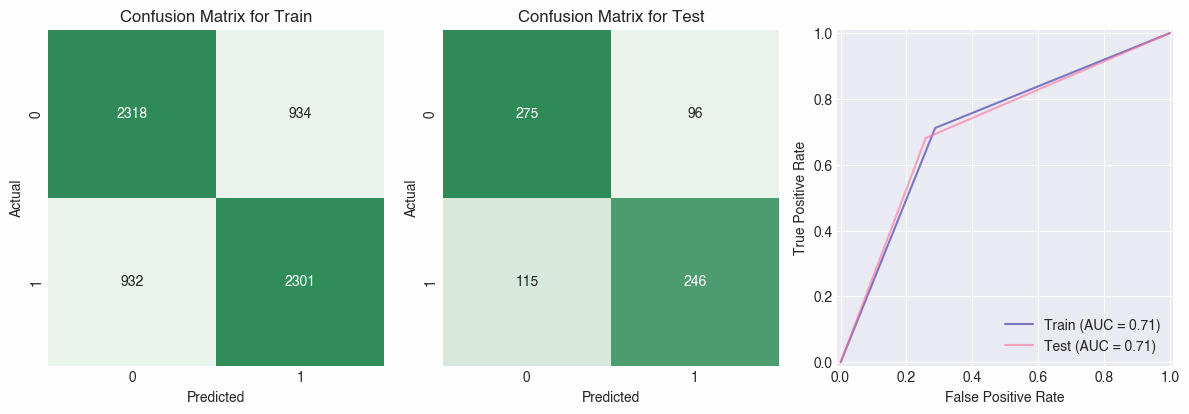

In [35]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=y_pred_train,
    y_train_proba=y_proba_train,
    y_test=y_test,
    y_test_pred=y_pred_test,
    y_test_proba=y_pred_proba_test,
)

### XGBoost Model Pred + Analysis

In [36]:
# xgb Pipeline Test
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['sp_fix_count',
                                                   'sp_fix_duration_ms_var',
                                                   'sp_len_px_total',
                                                   'sp_saccade_amplitude_px_mean',
                                                   'sp_saccade_amplitude_px_var',
                                                   'sp_distance_to_centre_px_mean',
                                                   'sp_distance_to_centre_px_var',
                                                   'sp_distance_to_sp_mean_px_mean',
                                                   'sp_distance_to_sp_mean_px_var',
                                                   'dg_sal_first...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [37]:
# Predict on the test set
y_pred_train = xgb_pipeline.predict(X_train)
y_proba_train = xgb_pipeline.predict_proba(X_train)
y_pred_test = xgb_pipeline.predict(X_test)
y_pred_proba_test = xgb_pipeline.predict_proba(X_test)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.734     0.715     0.724      3252
           1      0.720     0.739     0.729      3233

    accuracy                          0.727      6485
   macro avg      0.727     0.727     0.727      6485
weighted avg      0.727     0.727     0.727      6485

f(0.5)-score: 0.724
f(2.0)-score: 0.735

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.698     0.709     0.703       371
           1      0.696     0.684     0.690       361

    accuracy                          0.697       732
   macro avg      0.697     0.697     0.697       732
weighted avg      0.697     0.697     0.697       732

f(0.5)-score: 0.693
f(2.0)-score: 0.686



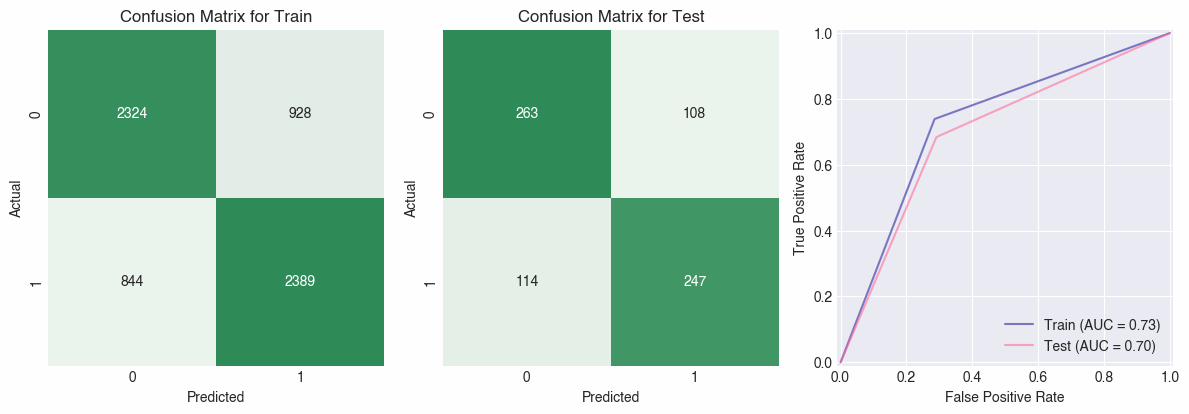

In [38]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=y_pred_train,
    y_train_proba=y_proba_train,
    y_test=y_test,
    y_test_pred=y_pred_test,
    y_test_proba=y_pred_proba_test,
)

# LADYS and GENTLEMAN!!! Thats why we here
## See the Performance of our Stacking Model
### With Grid Search and Evaluation

In [47]:
# Fit the grid search model
grid_search_pipeline.fit(X_train, y_train)


/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-pack

KeyboardInterrupt: 

### Evaluating our Master Model

In [ ]:
# Predict on the test set
y_pred_train = grid_search_pipeline.predict(X_train)
y_proba_train = grid_search_pipeline.predict_proba(X_train)
y_pred_test = grid_search_pipeline.predict(X_test)
y_pred_proba_test = grid_search_pipeline.predict_proba(X_test)

In [ ]:
# Fit the stacking classifier
stacking_pipeline_predict.fit(X_train, y_train)

# Predict on the test set
# Predict on the test set
y_pred_train = stacking_pipeline_predict.predict(X_train)
y_proba_train = stacking_pipeline_predict.predict_proba(X_train)
y_pred_test = stacking_pipeline_predict.predict(X_test)
y_pred_proba_test = stacking_pipeline_predict.predict_proba(X_test)